# End-to-end Masked Language Modeling with BERT

**Author:** [Ankur Singh](https://twitter.com/ankur310794)<br>
**Date created:** 2020/09/18<br>
**Last modified:** 2024/03/15<br>
**Description:** Implement a Masked Language Model (MLM) with BERT and fine-tune it on the IMDB Reviews dataset.

In [2]:
global_arr = ["cat"] 
class Dog:
    def __init__(self, c):
        global global_arr
        global_arr.append(c)
dog = Dog("dog")
print(global_arr)

['cat', 'dog']


## Introduction

Masked Language Modeling is a fill-in-the-blank task,
where a model uses the context words surrounding a mask token to try to predict what the
masked word should be.

For an input that contains one or more mask tokens,
the model will generate the most likely substitution for each.

Example:

- Input: "I have watched this [MASK] and it was awesome."
- Output: "I have watched this movie and it was awesome."

Masked language modeling is a great way to train a language
model in a self-supervised setting (without human-annotated labels).
Such a model can then be fine-tuned to accomplish various supervised
NLP tasks.

This example teaches you how to build a BERT model from scratch,
train it with the masked language modeling task,
and then fine-tune this model on a sentiment classification task.

We will use the Keras `TextVectorization` and `MultiHeadAttention` layers
to create a BERT Transformer-Encoder network architecture.

Note: This example should be run with `tf-nightly`.

## Setup

Install `tf-nightly` via `pip install tf-nightly`.

In [1]:
#checking the gpu is there (run this again after the next couple pip installs)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2024-04-05 23:52:04.188222: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 23:52:05.339035: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17468383392548077030
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 20615987200
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 14035956237778422088
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:a1:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2024-04-05 23:52:08.260371: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 19660 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:a1:00.0, compute capability: 8.6


In [3]:
# ! pip install tf-nightly[and-cuda]

In [4]:
! pip install keras-nlp keras-core tensorflow-text --no-deps

In [5]:
! pip install nltk

In [2]:
import nltk 

In [ ]:
nltk.download("all") 

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

In [4]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras_nlp
import keras
import tensorflow as tf
from keras import layers
from keras.layers import TextVectorization
from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint
from nltk.tokenize import WhitespaceTokenizer


Using TensorFlow backend


In [5]:
import re 

## Set-up Configuration

In [6]:

@dataclass
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 30000
    EMBED_DIM = 128
    NUM_HEAD = 8  # used in bert model
    FF_DIM = 128  # used in bert model
    NUM_LAYERS = 1


config = Config()

## Load the data

We will first download the IMDB data and load into a Pandas dataframe.

In [8]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  48.6M      0  0:00:01  0:00:01 --:--:-- 48.6M


In [7]:

def get_text_list_from_files(files):
    text_list = []
    for name in files:
        with open(name) as f:
            for line in f:
                text_list.append(line)
    return text_list


def get_data_from_text_files(folder_name):

    pos_files = glob.glob("aclImdb/" + folder_name + "/pos/*.txt")
    pos_texts = get_text_list_from_files(pos_files)
    neg_files = glob.glob("aclImdb/" + folder_name + "/neg/*.txt")
    neg_texts = get_text_list_from_files(neg_files)
    df = pd.DataFrame(
        {
            "review": pos_texts + neg_texts,
            "sentiment": [0] * len(pos_texts) + [1] * len(neg_texts),
        }
    )
    df = df.sample(len(df)).reset_index(drop=True)
    return df


train_df = get_data_from_text_files("train")
test_df = get_data_from_text_files("test")

all_data = pd.concat([train_df, test_df])
# train_df.concat(test_df)

In [8]:
all_data['review'][1]

1    Mary Poppins is definitely much better, but th...
1    The show is at least partially Faked (So is no...
Name: review, dtype: object

## Dataset preparation

We will use the `TextVectorization` layer to vectorize the text into integer token ids.
It transforms a batch of strings into either
a sequence of token indices (one sample = 1D array of integer token indices, in order)
or a dense representation (one sample = 1D array of float values encoding an unordered set of tokens).

Below, we define 3 preprocessing functions.

1.  The `get_vectorize_layer` function builds the `TextVectorization` layer.
2.  The `encode` function encodes raw text into integer token ids.
3.  The `get_masked_input_and_labels` function will mask input token ids.
It masks 15% of all input tokens in each sequence at random.

In [9]:
mask_for_debugging = None

In [ ]:
import sys 
instances = 0 
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~\""), "" # original line: "!#$%&'()*+,-./:;<=>?@\^_`{|}~"
    )


def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[MASK]"]):
    """Build Text vectorization layer

    Args:
      texts (list): List of string i.e input texts
      vocab_size (int): vocab size
      max_seq (int): Maximum sequence lenght.
      special_tokens (list, optional): List of special tokens. Defaults to ['[MASK]'].

    Returns:
        layers.Layer: Return TextVectorization Keras Layer
    """
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq,
    )
    vectorize_layer.adapt(texts)

    # Insert mask token in vocabulary
    vocab = vectorize_layer.get_vocabulary()
    vocab = vocab[2 : vocab_size - len(special_tokens)] + ["[mask]"]
    vectorize_layer.set_vocabulary(vocab)
    return vectorize_layer


vectorize_layer = get_vectorize_layer(
    all_data.review.values.tolist(),
    config.VOCAB_SIZE,
    config.MAX_LEN,
    special_tokens=["[mask]"],
)

# Get mask token id for masked language model
mask_token_id = vectorize_layer(["[mask]"]).numpy()[0][0]

#for decoding to create the masks 
id2token = dict(enumerate(vectorize_layer.get_vocabulary()))

def decode(tokens):
    return " ".join([id2token[t] for t in tokens if t != 0])

def encode(texts):
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.numpy()

def generate_mask(vectorized_txt): 
    global mask_for_debugging
    # print('vectorized_txt:') 
    # print(len(vectorized_txt))
    # print(vectorized_txt)
    pos_vals = {"D", "J", "N", "P", "V", "R"}
    map_to_pos = {"D":"verb", "J":"adj", "N":"noun", "P":"pronoun", "V":"verb", "R": "adverb"}
    relationships = {"noun": {"verb", "adj", "pronoun"},  "verb":{"noun", "adverb", "pronoun"}, "adj":{"noun", "pronoun"}, "pronoun":{"verb", "adj", "adverb", "noun"}, "adverb": {"verb"}}

    
    decoded_txt = "" 
    word_count =  0 
    #assuming the shape of vectorized_txt is (256,) 
    for i in range(len(vectorized_txt)):
        vectorized_word = vectorized_txt[i] 
        if vectorized_word == 0:
            break 
        else:
            #doing this in case the last word is a specialized space token and it gets stripped at the end 
            if i != len(vectorized_txt)-1 and vectorized_txt[i+1] != 0 :
                decoded_txt += decode([vectorized_word]) + " " 
            else:
                decoded_txt += decode([vectorized_word]) 
            word_count += 1 
    # print(word_count)
    # print(decoded_txt)

    remaining_vals = 256 - word_count #change this to config.MAX_SIZE afterwards 
    
    # tokenized = word_tokenize(decoded_txt)
    # tokenized=WhitespaceTokenizer().tokenize(decoded_txt)
    tokenized = decoded_txt.split(" ")
    tagged = nltk.pos_tag(tokenized)
    # print(f'length of tagged before processing {len(tagged)}') 
    # print(tagged)
    word_pos = []
    for j in range(len(tagged)): 
        word, pos = tagged[j] 
        if word == ']' and j != 0 and (tagged[j-1][0] == 'mask' or tagged[j-1][0] == 'UNK'):
            word_pos.pop(-1)
            word_pos.pop(-1)
                # print(decoded_txt) 
                # sys.quit() 
            word_pos.append(None) 
        elif ord(word[0]) >= 127 and len(word) == 1 or pos[0] not in pos_vals: 
            word_pos.append(None)
        else:
            word_pos.append(map_to_pos[pos[0]]) 

    # print(f'after processing {len(word_pos)}')
    # print(word_pos)

    mask = np.ones((len(word_pos), len(word_pos)))

    for row in range(mask.shape[0]):
        row_word_pos = word_pos[row] 
        if row_word_pos: #the [CLS], [SEP], and [MASK] tokens will be allowed to be influenced by every word 
            allowed_pos = relationships[row_word_pos] 
            for col in range(mask.shape[1]): 
                #for now, don't worry about the [mask] token not being allowed to influence the words 
                if word_pos[col] not in allowed_pos: 
                    mask[row,col] = 0
                # else:
                #     mask[row, col] = 0 

    np.fill_diagonal(mask, 1) 

    if remaining_vals > 0: 
        true_mask = np.zeros((256, 256)) #change this to config.MAX_SIZE afterwards 
        try:
            true_mask[:word_count, :word_count] = mask 
        except:
            print(f'mask shape: {mask.shape}') 
            print(f'word_count: {word_count}')
            mask_for_debugging = vectorized_txt 
            print(decoded_txt)
            sys.quit()
        mask = true_mask
    
    return mask 

    
def get_masked_input_and_labels(encoded_texts):
    # 15% BERT masking
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    # Do not mask special tokens
    inp_mask[encoded_texts <= 2] = False
    # Set targets to -1 by default, it means ignore
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    # Set labels for masked tokens
    labels[inp_mask] = encoded_texts[inp_mask]

    # Prepare input
    encoded_texts_masked = np.copy(encoded_texts)
    # Set input to [MASK] which is the last token for the 90% of tokens
    # This means leaving 10% unchanged
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[
        inp_mask_2mask
    ] = mask_token_id  # mask token is the last in the dict

    # Set 10% to a random token
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        3, mask_token_id, inp_mask_2random.sum()
    )

    # Prepare sample_weights to pass to .fit() method
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0

    # y_labels would be same as encoded_texts i.e input tokens
    y_labels = np.copy(encoded_texts)

    all_syntactic_masks = [] 
    # c = 0 
    for sentence in encoded_texts_masked:
        # print(c)
        all_syntactic_masks.append(generate_mask(sentence)) 
        # c += 1 

    # count = 0
    # for sentence in encoded_texts_masked:
    #     if count == 3: 
    #         break 
    #     print(f'count: {count}, decoded sentence: {decode(sentence)}')
    #     count += 1 

    # #decode for masking 
    # all_syntactic_masks = [] 
    # for sentence in encoded_texts_masked: 
    #     decoded_sentence = decode(sentence) 
    #     temp = "[CLS] " + decoded_sentence + " [SEP]" 
    #     syntactic_mask = generate_mask(temp)
    #     all_syntactic_masks.append(syntactic_mask) 
    # print(f'all_syntatic_masks shape: {len(all_syntactic_masks)}')
    # # count = 1 
    # # for sentence in encoded_texts_masked:
    # #     if count == 3: 
    # #         break 
    # #     print(f'count: {count}, decoded sentence: {decode(sentence)}')
    # #     count += 1 

    return encoded_texts_masked, y_labels, sample_weights, all_syntactic_masks


# We have 25000 examples for training
x_train = encode(train_df.review.values)  # encode reviews with vectorizer
y_train = train_df.sentiment.values
train_classifier_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1000)
    .batch(config.BATCH_SIZE)
)

# We have 25000 examples for testing
x_test = encode(test_df.review.values)
y_test = test_df.sentiment.values
test_classifier_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(
    config.BATCH_SIZE
)

# Build dataset for end to end model input (will be used at the end)
test_raw_classifier_ds = tf.data.Dataset.from_tensor_slices(
    (test_df.review.values, y_test)
).batch(config.BATCH_SIZE)

# Prepare data for masked language model
x_all_review = encode(all_data.review.values)
x_masked_train, y_masked_labels, sample_weights, syntactic_masks = get_masked_input_and_labels(
    x_all_review
)

mlm_ds = tf.data.Dataset.from_tensor_slices(
    (x_masked_train, y_masked_labels, sample_weights)
)
mlm_ds = mlm_ds.shuffle(1000).batch(config.BATCH_SIZE)

2024-04-05 23:52:20.412377: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19660 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:a1:00.0, compute capability: 8.6


In [21]:
mask_for_debugging

array([   53,   576,    48, 29999,  1044,    17,     9, 29999,  1513,
          69, 29999,    73,     5,     2,   724,   128, 29999,  3350,
       13592, 29999,    72, 29999,  1168,    50,     2,  1065, 29999,
          21, 29999,   491,    40,   636, 29999,     3,     2, 29999,
         128,     8,  4294, 19231,    50,     2,   698,  1795,   529,
           6,  1193,  6944,    43,    31,  1526,  7389,    38,    22,
       29999,   576,   334,     2,  3230,    12,   264,     6,   308,
          15, 29999,   265,    31,  7938,    92,   290,     3,    22,
          57, 21862,   189, 29999,     6,     1,     2,   427, 20155,
        1735,     2,    65, 29999,     2,     1, 18855,   197,    26,
         145,   189,    18,     2,    17,    97, 29999,   222,   200,
          31, 29999,   303,  5411, 27337,  2301,  3672,     6, 29999,
          47,    66, 17058, 17334,     8,     2,   437,   295,     2,
           1,   128, 28152,  4294, 19231,    56,  3872,   337,     2,
         422, 18855,

In [ ]:
encoded_texts = np.ones((256,1))
inp_mask = np.random.rand(*encoded_texts.shape) < 0.15

In [19]:
x_all_review[50]

array([   10,   228,   447,  5965,     6,    11,   118,    10,   173,
         846,  2285,     2,  1241,   264,    32,     6,    64,     2,
         356,   739,    29,     4,    80,    65,   361,     3,     9,
          45,     2,   115,   149,     3,  1612,    20,     2,   118,
          10,    77,  3018,     8,   167,  1241,     6,   103,     9,
          54,    43,    10,   228,    21,   338,    10,   205,    25,
          53,  7401,   284,     6,  1899, 16500, 29222,  2580,  5054,
           7,     2,   115,   294,    20,     2,   118,     9,     7,
        2428,     3,  1125,    10,   102,    11,   118,   140,   764,
          20,     2,   940,     3,    10,   252,   298,   140,  3018,
           8,     6,   103,     9,    10,   204,     2,    52,    88,
         389,     3,   155,    10,   277,   162,     6,   103,     9,
          18,    10,    13,   144,  2584,    28,   260,     3,    10,
         849,     6,   103,     9,    84,     9,    13,    20,     3,
          10,   409,

In [13]:
syntactic_masks[50].shape

(142, 142)

In [1]:
x_all_review[11149]

NameError: name 'x_all_review' is not defined

In [19]:
txt = '[CLS] loony tunes [mask] ventured at least twice [mask] the future the first time was with the brilliantly [mask] duck [UNK] the latter time was with this  um  effort [UNK] unleashed [mask] without merit and might be considered [mask] good product were it not that it isnt up [mask] warner brothers quality wb [mask] are noted for their cheeky humor appealing at [mask] as much to [mask] as to children these pedestrian superhero episodes on the other hand cannot fail [mask] convince adults to pass them up the premise of the series [mask] that 6 ordinary individuals 2 bunnies [mask] [UNK] [mask] a [mask] a [mask] and a coyote live on the [UNK] of [UNK] and acquire super powers when a meteor strikes the planet in [UNK] whats confusing is that the titles section features these individuals with a [UNK] to [UNK] from the 21st century cute but [UNK] stupid in each episode the [mask] [UNK]  amid [mask] amusing but essentially banal banter  fight various super [mask] [mask] the most part these are types that appear in [mask] mediocre [mask] adventure series and even some of the better ones like many [mask] superhero series this one takes [mask] villains far [mask] seriously [mask] the context and of course these guys are the only [mask] that laugh  the usual evil laugh of course [mask] is it that villains [mask] predictable [mask] adventures always  always  [mask] [UNK] at every opportunity animated material of [mask] sort seems [mask] leave laughter exclusively in the [SEP]'
decode(vectorize_layer(['[MASK]'])[0].numpy())
# vectorize_layer([txt])[0].numpy()

'[mask]'

In [18]:
x_all_review.shape

(50000, 256)

In [17]:
all_data.review.values.shape

(50000,)

In [39]:
all_data.review.values.tolist()[0:3]

['As predictable as a Hallmark card, but not without merit, The Rookie makes for a solid outing. Dennis Quaid, the most reasonable jock actor working today, is absolutely perfect as the science teacher turned baseball player Jimmy Morris. The film is never dumbed down for the children, as would be expected from a G rated film. As a sports film, The Rookie is one of the best I have seen since Any Given Sunday.',
 "If The Man in the White Suit had been done in America, can't you see either Danny Kaye or Jerry Lewis trying on Alec Guinness's Sidney Stratton on for size?<br /><br />This is one of the best of Alec Guinness's films and certainly one of the best that Ealing Studios in the United Kingdom ever turned out. It's so perfectly fits within the time frame of the new Labour government and the society it was trying to build. It's amazing how in times of crisis capital and labor can agree.<br /><br />Alec Guinness this meek little schnook of a man is obsessed with the idea that he can i

## Create BERT model (Pretraining Model) for masked language modeling

We will create a BERT-like pretraining model architecture
using the `MultiHeadAttention` layer.
It will take token ids as inputs (including masked tokens)
and it will predict the correct ids for the masked input tokens.

In [13]:
from tensorflow import math, matmul, reshape, shape, transpose, cast, float32
from tensorflow.keras.layers import Dense, Layer
from keras.backend import softmax

attentions = [] 

# Implementing the Scaled-Dot Product Attention
class DotProductAttention(Layer):
    def __init__(self, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)

    def call(self, queries, keys, values, d_k, mask=None):
        global attentions 
        # Scoring the queries against the keys after transposing the latter, and scaling
        scores = matmul(queries, keys, transpose_b=True) / math.sqrt(cast(d_k, float32))

        # Apply mask to the attention scores
        if mask is not None:
            scores += -1e9 * mask

        # Computing the weights by a softmax operation
        weights = softmax(scores)
        # print(f'attention matrix shape {weights.shape}')
        if len(attentions) == 1:
            attentions.pop() 
        # print("appending to attentions")
        attentions.append(weights)

        # Computing the attention by a weighted sum of the value vectors
        return matmul(weights, values)

# Implementing the Multi-Head Attention
class MultiHeadAttention(Layer):
    def __init__(self, h, d_k, d_v, d_model, output_attention=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.attention = DotProductAttention()  # Scaled dot product attention
        self.heads = h  # Number of attention heads to use
        self.d_k = d_k  # Dimensionality of the linearly projected queries and keys
        self.d_v = d_v  # Dimensionality of the linearly projected values
        self.d_model = d_model  # Dimensionality of the model
        self.W_q = Dense(d_k)  # Learned projection matrix for the queries
        self.W_k = Dense(d_k)  # Learned projection matrix for the keys
        self.W_v = Dense(d_v)  # Learned projection matrix for the values
        self.W_o = Dense(d_model)  # Learned projection matrix for the multi-head output

    def reshape_tensor(self, x, heads, flag):
        if flag:
            # Tensor shape after reshaping and transposing: (batch_size, heads, seq_length, -1) (32, 8, 256, 128?) 
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], heads, -1))
            x = transpose(x, perm=(0, 2, 1, 3))
        else:
            # Reverting the reshaping and transposing operations: (batch_size, seq_length, d_k)
            x = transpose(x, perm=(0, 2, 1, 3))
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], self.d_k))
        return x

    def call(self, queries, keys, values, mask=None):
        # Rearrange the queries to be able to compute all heads in parallel
        q_reshaped = self.reshape_tensor(self.W_q(queries), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the keys to be able to compute all heads in parallel
        k_reshaped = self.reshape_tensor(self.W_k(keys), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange the values to be able to compute all heads in parallel
        v_reshaped = self.reshape_tensor(self.W_v(values), self.heads, True)
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Compute the multi-head attention output using the reshaped queries, keys and values
        o_reshaped = self.attention(q_reshaped, k_reshaped, v_reshaped, self.d_k, mask)
        # print(f'attention shape: {o_reshaped.shape}')
        # Resulting tensor shape: (batch_size, heads, input_seq_length, -1)

        # Rearrange back the output into concatenated form
        output = self.reshape_tensor(o_reshaped, self.heads, False)
        # Resulting tensor shape: (batch_size, input_seq_length, d_v)

        # Apply one final linear projection to the output to generate the multi-head attention
        # Resulting tensor shape: (batch_size, input_seq_length, d_model)
        return self.W_o(output)

In [14]:
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self,
        init_lr=0.00001,
        lr_after_warmup=0.001,
        final_lr=0.00001,
        warmup_epochs=15,
        decay_epochs=85,
        steps_per_epoch=203,
    ):
        super().__init__()
        self.init_lr = init_lr
        self.lr_after_warmup = lr_after_warmup
        self.final_lr = final_lr
        self.warmup_epochs = warmup_epochs
        self.decay_epochs = decay_epochs
        self.steps_per_epoch = steps_per_epoch

    def calculate_lr(self, epoch):
        """linear warm up - linear decay"""
        warmup_lr = (
            self.init_lr
            + ((self.lr_after_warmup - self.init_lr) / (self.warmup_epochs - 1)) * epoch
        )
        decay_lr = tf.math.maximum(
            self.final_lr,
            self.lr_after_warmup
            - (epoch - self.warmup_epochs)
            * (self.lr_after_warmup - self.final_lr)
            / self.decay_epochs,
        )
        return tf.math.minimum(warmup_lr, decay_lr)

    def __call__(self, step):
        epoch = step // self.steps_per_epoch
        epoch = tf.cast(epoch, "float32")
        return self.calculate_lr(epoch)

optimizer = keras.optimizers.Adam(learning_rate=CustomSchedule())

In [15]:

def bert_module(query, key, value, i, use_custom=True):
    # Multi headed self-attention
    attention_ouput=None
    if use_custom:
        attention_output = MultiHeadAttention(h=config.NUM_HEAD, d_k=(config.EMBED_DIM // config.NUM_HEAD), d_v=(config.EMBED_DIM // config.NUM_HEAD), d_model=config.EMBED_DIM, name="encoder_{}_multiheadattention".format(i))(query, key, value)
    else:
        attention_output = layers.MultiHeadAttention(
            num_heads=config.NUM_HEAD,
            key_dim=config.EMBED_DIM // config.NUM_HEAD,
            name="encoder_{}_multiheadattention".format(i),
        )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}_att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_{}_ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}_ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


loss_fn = keras.losses.SparseCategoricalCrossentropy(reduction="none")
loss_tracker = keras.metrics.Mean(name="loss")


class MaskedLanguageModel(keras.Model):
    def train_step(self, inputs):
        #here is where we would seperate the input and the masks 
        if len(inputs) == 3:
            features, labels, sample_weight = inputs
        else:
            features, labels = inputs
            sample_weight = None

        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = loss_fn(labels, predictions, sample_weight=sample_weight)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker]


def create_masked_language_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")

    word_embeddings = layers.Embedding(
        config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding"
    )(inputs)
    position_embeddings = keras_nlp.layers.PositionEmbedding(
        sequence_length=config.MAX_LEN
    )(word_embeddings)
    embeddings = word_embeddings + position_embeddings

    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i)

    mlm_output = layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(
        encoder_output
    )
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")

    # optimizer = keras.optimizers.AdamW(learning_rate=config.LR)
    optimizer = keras.optimizers.Adam(learning_rate=CustomSchedule())
    mlm_model.compile(optimizer=optimizer, metrics=["accuracy"], run_eagerly=True) #add parameter run_eagerly=True for running in eager mode
    return mlm_model


id2token = dict(enumerate(vectorize_layer.get_vocabulary()))
token2id = {y: x for x, y in id2token.items()}


class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k

    def decode(self, tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        return id2token[id]

    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(self.sample_tokens)

        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[1]
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[-self.k :][::-1]
        values = mask_prediction[0][top_indices]

        for i in range(len(top_indices)):
            p = top_indices[i]
            v = values[i]
            tokens = np.copy(sample_tokens[0])
            tokens[masked_index[0]] = p
            result = {
                "input_text": self.decode(sample_tokens[0].numpy()),#add sample_tokens[0].numpy() if it doesnt work
                "prediction": self.decode(tokens),
                "probability": v,
                "predicted mask token": self.convert_ids_to_tokens(p),
            }
            pprint(result)


sample_tokens = vectorize_layer(["I have watched this [mask] and it was awesome"])
generator_callback = MaskedTextGenerator(sample_tokens.numpy())

bert_masked_model = create_masked_language_bert_model()
bert_masked_model.summary()

Model: "masked_bert_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 word_embedding (Embedding)  (None, 256, 128)             3840000   ['input_1[0][0]']             
                                                                                                  
 position_embedding (Positi  (None, 256, 128)             32768     ['word_embedding[0][0]']      
 onEmbedding)                                                                                     
                                                                                                  
 tf.__operators__.add (TFOp  (None, 256, 128)             0         ['word_embeddi

## Train and Save

In [16]:
bert_masked_model.fit(mlm_ds, epochs=25, callbacks=[generator_callback])
bert_masked_model.save("bert_mlm_imdb.keras")

Epoch 1/25


2024-04-01 03:23:21.462766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-01 03:23:22.010372: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5600a713afb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-01 03:23:22.010447: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-01 03:23:22.032254: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-01 03:23:22.195035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-01 03:23:22.380322: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

1/1 [==============================] - 0s 26ms/steps - loss: 7.75
{'input_text': 'i have watched this [mask] and it was awesome',
 'predicted mask token': 'this',
 'prediction': 'i have watched this this and it was awesome',
 'probability': 0.05356184}
{'input_text': 'i have watched this [mask] and it was awesome',
 'predicted mask token': 'movie',
 'prediction': 'i have watched this movie and it was awesome',
 'probability': 0.035384145}
{'input_text': 'i have watched this [mask] and it was awesome',
 'predicted mask token': 'a',
 'prediction': 'i have watched this a and it was awesome',
 'probability': 0.034424987}
{'input_text': 'i have watched this [mask] and it was awesome',
 'predicted mask token': 'i',
 'prediction': 'i have watched this i and it was awesome',
 'probability': 0.033160124}
{'input_text': 'i have watched this [mask] and it was awesome',
 'predicted mask token': 'it',
 'prediction': 'i have watched this it and it was awesome',
 'probability': 0.029096832}
1563/1563

NotImplementedError: Learning rate schedule 'CustomSchedule' must override `get_config()` in order to be serializable.

In [17]:
attention = attentions[0]
attention = attention.numpy()
print(attention)

[[[[6.2163699e-02 1.7237583e-02 8.2696289e-02 ... 1.0992441e-03
    7.6986058e-04 1.5021606e-03]
   [1.2154877e-02 7.5936848e-03 1.3497258e-02 ... 2.7682991e-03
    2.4291540e-03 3.1041517e-03]
   [1.0017248e-01 1.9970922e-02 1.4273998e-01 ... 6.1508315e-04
    3.9450894e-04 9.1180980e-04]
   ...
   [3.1742404e-04 8.2923233e-04 2.5627049e-04 ... 6.5006632e-03
    8.4893536e-03 5.1458795e-03]
   [1.2958751e-04 4.7003632e-04 9.7245524e-05 ... 7.4491552e-03
    1.0656916e-02 5.4439828e-03]
   [1.8146719e-04 5.7994563e-04 1.4034878e-04 ... 7.0642545e-03
    9.7418763e-03 5.3218575e-03]]

  [[1.7115727e-02 1.9844633e-02 2.5542544e-02 ... 2.0763951e-03
    1.4171037e-03 2.2735444e-03]
   [8.5389279e-03 9.7096181e-03 1.1389668e-02 ... 2.8663762e-03
    2.2410376e-03 2.9508844e-03]
   [3.1036781e-02 3.2134797e-02 4.1619256e-02 ... 1.5916503e-03
    1.0926903e-03 1.9199133e-03]
   ...
   [2.0031934e-03 1.8061243e-03 1.5893610e-03 ... 4.7820858e-03
    5.8247927e-03 4.6744379e-03]
   [1.8170547e

In [18]:
sample_tokens = vectorize_layer(["I didn't watch this [mask] and it was awesome"]).numpy()
prediction = bert_masked_model.predict(sample_tokens)

1/1 [==============================] - 0s 28ms/step


In [19]:
attention = attentions[0].numpy()
print(attention.shape)

(1, 8, 256, 256)


In [20]:
np.expand_dims(attention[0][:, :11, :11], axis=0).shape

(1, 8, 11, 11)

In [29]:
import torch
test = np.expand_dims(attention[0][:, :11, :11], axis=0)
fin = torch.from_numpy(test)
fin = (fin,)

In [30]:
fin[0][0].size(0)

8

In [31]:
print(fin[0].size(0))

1


In [24]:
! pip install bertviz

  Obtaining dependency information for bertviz from https://files.pythonhosted.org/packages/66/07/cce3d29605a3011d3685b2041fb94fcad25565b80bd2f22f3dcd75b2eee9/bertviz-1.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for transformers>=2.0 from https://files.pythonhosted.org/packages/e2/52/02271ef16713abea41bab736dfc2dbee75e5e3512cf7441e233976211ba5/transformers-4.39.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.2 MB/s eta 0:00:00
  Obtaining dependency information for boto3 from https://files.pythonhosted.org/packages/fe/61/2561a979dabf221724b0de8d5ba9c6f42950fea689ebfca304e8ee943d68/boto3-1.34.74-py3-none-any.whl.metadata
  Obtaining dependency information for sentencepiece from https://files.pythonhosted.org/packages/fb/12/2f5c8d4764b00033cf1c935b702d3bb878d10be9f0b87f0253495832d85f/sentencepiece-0.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for huggingface-hub<

In [32]:
print('didn\'t')

didn't


In [33]:
tokens = ['[CLS]', 'I', 'didn\'t',  'watch', 'this', '[mask]', 'and', 'it' , 'was' ,'awesome', '[SEP]']

In [34]:
from bertviz import model_view
model_view(fin, tokens)

ValueError: Attention has 12 positions, while number of tokens is 11 for tokens: [CLS] I didn't watch this [mask] and it was awesome [SEP]

In [149]:
test = (attention)
type(test[0][0])

numpy.ndarray

In [135]:
attention[0][0][:15, :15].shape

(15, 15)

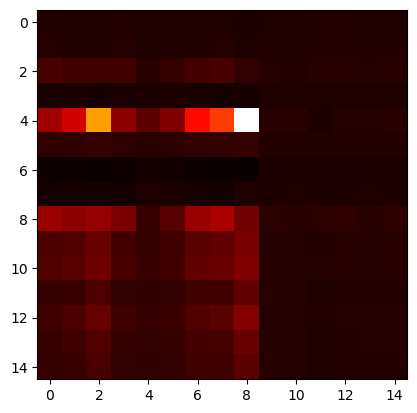

In [136]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(attention[0][0][:15, :15], cmap='hot', interpolation='nearest')
plt.show()

In [128]:
maxes = np.max(attention[0], axis=2)
print(maxes.shape)

(8, 256)


In [129]:
print(maxes[0])

[0.00404038 0.00431366 0.00800652 0.00412699 0.06825823 0.00599015
 0.0046205  0.0042967  0.01767619 0.01275809 0.01308699 0.01029907
 0.01391248 0.01109591 0.00975572 0.0130958  0.01381197 0.01604069
 0.01219762 0.01285662 0.01153841 0.00933414 0.01637969 0.01421819
 0.01336755 0.0125869  0.00819856 0.0137931  0.01253239 0.01143891
 0.01325539 0.01223965 0.0111608  0.01391155 0.01352924 0.01043962
 0.01208384 0.00876712 0.01019692 0.00983819 0.00643459 0.01089945
 0.01103907 0.00815692 0.00821381 0.00880244 0.01061832 0.00927905
 0.00969109 0.00941637 0.01083732 0.00668062 0.0070617  0.01109327
 0.01069188 0.01025999 0.00866607 0.00784996 0.00874485 0.0124323
 0.0110821  0.00773306 0.00919802 0.01015149 0.01082272 0.00836784
 0.00893945 0.00931748 0.01066061 0.00738861 0.01168074 0.01132177
 0.00689708 0.00781994 0.00681903 0.01027065 0.01008957 0.01088495
 0.00759991 0.01004521 0.00975106 0.00587125 0.00814002 0.00858609
 0.00871364 0.0117429  0.01105649 0.0088146  0.00699021 0.00752

In [ ]:
mask_token_id = vectorize_layer(["[mask]"]).numpy()[0][0]
k = 5

sample_tokens = vectorize_layer(["I have watched this [mask] and it was awesome"]).numpy()
prediction = bert_masked_model.predict(sample_tokens)
masked_index = np.where(sample_tokens == mask_token_id)[1]
mask_prediction = prediction[0][masked_index]

top_indices = mask_prediction[0].argsort()[-1*k:][::-1]
values = mask_prediction[0][top_indices]

def decode(tokens):
    return " ".join([id2token[t] for t in tokens if t != 0])

def convert_ids_to_tokens(id):
    return id2token[id]

for i in range(len(top_indices)):
    p = top_indices[i]
    v = values[i]
    tokens = np.copy(sample_tokens[0])
    tokens[masked_index[0]] = p
    result = {
        "input_text": decode(sample_tokens[0]),
        "prediction": decode(tokens),
        "probability": v,
        "predicted mask token": convert_ids_to_tokens(p),
    }
    pprint(result)

In [ ]:
values

In [ ]:
# Load pretrained bert model
mlm_model = keras.models.load_model(
    "bert_mlm_imdb.keras", custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)
pretrained_bert_model = keras.Model(
    mlm_model.input, mlm_model.get_layer("encoder_0_ffn_layernormalization").output
)

# Freeze it
pretrained_bert_model.trainable = False


def create_classifier_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")
    sequence_output = pretrained_bert_model(inputs)
    pooled_output = layers.GlobalMaxPooling1D()(sequence_output)
    hidden_layer = layers.Dense(64, activation="relu")(pooled_output)
    outputs = layers.Dense(1, activation="sigmoid")(hidden_layer)
    classifer_model = keras.Model(inputs, outputs, name="classification")
    optimizer = keras.optimizers.AdamW(lr=1e-5)
    classifer_model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return classifer_model


classifer_model = create_classifier_bert_model()
classifer_model.summary()

# Train the classifier with frozen BERT stage
classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)

# Unfreeze the BERT model for fine-tuning
pretrained_bert_model.trainable = True
optimizer = keras.optimizers.Adam()
classifer_model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)
classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)

## Create an end-to-end model and evaluate it

When you want to deploy a model, it's best if it already includes its preprocessing
pipeline, so that you don't have to reimplement the preprocessing logic in your
production environment. Let's create an end-to-end model that incorporates
the `TextVectorization` layer, and let's evaluate. Our model will accept raw strings
as input.

In [ ]:

def get_end_to_end(model):
    inputs_string = keras.Input(shape=(1,), dtype="string")
    indices = vectorize_layer(inputs_string)
    outputs = model(indices)
    end_to_end_model = keras.Model(inputs_string, outputs, name="end_to_end_model")
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    end_to_end_model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return end_to_end_model


end_to_end_classification_model = get_end_to_end(classifer_model)
end_to_end_classification_model.evaluate(test_raw_classifier_ds)

In [ ]:
#find a way to visualize the attention
bert_masked_model.summary()

In [ ]:
#predicting (mlm task)
